# This calculates, summarizes, exports, plots the Fiji image quantification
Uses Fiji generated .txt files as input. Adapted to different protein names.  
Exports results and summarized results as excel file.  
Generates violinplots out of all single cells.

## Initial processing and plotting of individual replicates

In [1]:
""" open folders sequentially to combine all summary files into one dict, which is used subsequently """

import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import numpy as np
import re

rawfiles = {}
# --- GUI setup---
root = tk.Tk()
root.withdraw()

while True:
    folder_selected = filedialog.askdirectory(title="Choose folder with files, 'Cancel' when you're done, to continue")
    if not folder_selected:  # user cancelled
        break # exits whhile loop
    
    try:
        folder_exp = re.findall(r'(AP\d{2})', folder_selected)[0]
        folder_date = re.findall(r'(\d{6})', folder_selected)[1]
    except IndexError:
        print("No date")

    for filename in sorted(os.listdir(folder_selected)):
        print(filename)
        file_path = os.path.join(folder_selected, filename)
        if filename.startswith("._") or filename.startswith("~$"):
            continue
        file_name, file_extension = os.path.splitext(filename)

        if file_extension == ".txt":            
            file_data = pd.read_csv(file_path, delimiter="\t", encoding='latin1')
        elif file_extension == ".csv":
            file_data = pd.read_csv(file_path, encoding='latin1')
        else:
            continue
        if "Summary" in file_name: # exclude other files in the folder
            continue
        rawfiles[f"{folder_exp},{folder_date} {file_name}"] = file_data

root.destroy()

rawfiles.keys()

dict_keys([])

In [ ]:
import pandas as pd
pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import re

def Filter (rawfiles):
    """ initial processing: remove columns and combine cell & organelle measurements in one row
    unprocessed txt files have cell and organelle measurements underneath and not assigned to each other yet
    some cells don't have a matching organelle, column names are the same
    fiji thresholding information is on bottom two rows and don't contain measurements
    """
    files = rawfiles.copy()
    
    regex = r"(?P<date>^\w*,*\d*) ?(?P<POI>\w+)-?\w* (?P<cond>.+)_\d*" #when dict key is: (AP00,date) POI condition_replicate
    
    global POI
    ordered_files = {}
    
    # loop through all single files stored in the dict and rename, sort, assign each organelle to their cell.
    for name, data in files.items():
        POI = re.search(regex, name).group("POI")
        cond = re.search(regex, name).group("cond")

    # rename channel names automatically and manually.
        channel_rename = {
            "channel 2": POI,
            "channel 3": POI,
            "channel 1": "Sec63-Scarlet"
        }
    #Drop the bottom rows & other unncessary columns & rename
        data = data.dropna() #remove all rows without measurements
        #data = data.iloc[:-2] #drop 2 bottom rows
        proc_data = data.drop(columns=[' ','MinThr','MaxThr','Message'])
        proc_data.columns = [re.sub(r'^Mean', 'Px Int Mean', col) for col in proc_data.columns]
        proc_data.columns = [re.sub(r'^Median', 'Px Int Median', col) for col in proc_data.columns]
    
    #Generate new index based on Label numbers "POI-sfGFP nt_002_cell channel 2:0001-0054"
        #num_pattern = r"^.*_(?P<org>\w*) (?P<channel>.*):(?P<num>\d*)-\d*" #match organelle, channel x and number before -
    #Generate new index based on Label numbers "Prc1 DTT_:1_cell channel 2:c:2/3 - 1 DTT_.nd2 (series 1)"
        num_pattern = r"^.*_\d*:(?P<num>\d*)_(?P<org>\w+) (?P<channel>.+\d+):.*" #match cell number, organelle, channel x 
    #go through Label and extract channels and numbers in different columns, generate new index
        proc_data[['Cell_No', 'Organelles', 'Channel']] = proc_data['Label'].str.extract(num_pattern)
        proc_data['Cell_No'] = proc_data['Cell_No'].astype(int)
        proc_data["Channel"] = proc_data["Channel"].map(channel_rename) #rename channels with definded dict POI name
    #Split dfs based on channel and organelle, merge the same channels 
    #aka match each invidual measured cell with its matching organelle
        for channel in proc_data["Channel"].unique():
            if channel == "GFP_bkg" or channel == "Sec63-Scarlet":
                continue #remove Sec63-Scarlet from the final dfs
            else:
        # 1. Split/ Filter df by channel
                ch_df = proc_data[proc_data["Channel"] == channel]
            
        # 2. Split df again by organelle and store in dict
    #generate global variables which can be called outside this function and in other functions
            global organelles # a list
            global ref_org # a value of this list
            organelles = ch_df["Organelles"].unique()
            org_df = {org: ch_df[ch_df["Organelles"] == org] for org in organelles}
        # 3. Start with the first organelle
            ref_org = organelles[0]
            for org in organelles:
                if org == ref_org:
            # Rename columns to add organelle
                    organelle_base = (org_df[org]
                                      .drop(columns="Organelles")
                                      .rename(columns=lambda col: f"{col}_{org}" if col not in ["Cell_No", "Label", "Channel"] else col)
                    )
        
        # 4. Merge with all other dfs filtered by organelle
                else:
                    organelle_x = (org_df[org]
                                   .drop(columns="Organelles")
                                   .rename(columns=lambda col: f"{col}_{org}" if col not in ["Cell_No", "Label", "Channel"] else col)
                    )
        # 5. Merge dfs: Combine cell with ER, tidy up
                    organelle_base = (pd.merge(organelle_base, 
                                              organelle_x.drop(columns=["Label"]), 
                                              on=["Cell_No", "Channel"], how="left")
                                      .drop(columns=["Label", "Channel"])
                                      .dropna()
                                     )
        
                    ordered_files[f"{name} {channel}"] = organelle_base
    return ordered_files

def Calculate (filtered):
    """renames columns according to measured organelle, calculates Mean and Standard Error for each seperate file (field of view)
    """
    files = filtered.copy()
    calc_files = {}

    for name, file in files.items():
        sorted_cols = []

    #Generate new df to store summarized results  
        summary = pd.DataFrame(columns=[""])
        summary.loc[0] = [None] #dummy row necessary to add new rows
        
        for org in organelles:        
    #Calculate total signal (area*mean value) and signal per cell (mean value/ area)
            file[f"Total Signal_{org}"] = file.loc[:,f"Area_{org}"] * file.loc[:,f"Px Int Mean_{org}"]
            file[f'Signal per Cell_{org}'] = file.loc[:, f"Px Int Mean_{org}"] / file.loc[:,f"Area_{org}"]
    #Sort columns together of the same organelle and use to sort columns in the final file
            org_cols = [col for col in file.columns if col.endswith(f"_{org}")]
            sorted_cols.extend(org_cols)

    #Calculate Mean and Standard Error of the intensities, signal, area
            summary[f"Mean: Area_{org}"] = file[f"Area_{org}"].mean()
            summary[f"Mean: Px Int_{org}"] = file[f"Px Int Mean_{org}"].mean()
            summary[f"SEM: Px Int_{org}"] = file[f"Px Int Mean_{org}"].sem()
            summary[f"Mean: Total Signal_{org}"] = file[f"Total Signal_{org}"].mean()
            summary[f"SEM: Total Signal_{org}"] = file[f"Total Signal_{org}"].sem()
    #Calculate ratio of organelle (e.g. ER) intensity and fraction of organelle (ER) signal in the whole cell          
            if org != ref_org:
                file[f"{org} enrichment"] = file.loc[:,f"Px Int Mean_{org}"]/ file.loc[:,f"Px Int Mean_{ref_org}"]  
                file[f"{org} fraction"] = file.loc[:,f"Total Signal_{org}"] / file.loc[:,f"Total Signal_{ref_org}"]
                summary[f"Mean: {org} enrichment"] = file[f"{org} enrichment"].mean()
                summary[f"SEM: {org} enrichment"] = file[f"{org} enrichment"].sem()
                summary[f"Mean: {org} fraction"] = file[f"{org} fraction"].mean()
                summary[f"SEM: {org} fraction"] = file[f"{org} fraction"].sem()
        summary[f"# of cells"] = file[f"Cell_No"].count()
    #Use the specific order to sort file columns
        other_cols = [col for col in file.columns if col not in sorted_cols]
        file = file[sorted_cols + other_cols]
    #Merge the two dataframes
        
        final = (file.join(summary.drop(columns=""), how="outer")
                 .set_index("Cell_No")
                )
        calc_files[name] = final
    return calc_files

def load_bkg ():
    """uploads background file which contains mean bkg pixel"""
    root = tk.Tk()
    root.withdraw()

    bkg_path = filedialog.askopenfilename(title="Please select the bkg.xlsx file")

    print("bkg file:", bkg_path)
    root.destroy()
    
    bkg_file = pd.read_excel(bkg_path, sheet_name="CombinedSummary", index_col=[1,2]) #define which columns are the multiindex
    bkg_file = bkg_file.rename(index={"ctrl":POI}, level="Channel")
    return bkg_file

def BkgSub_Calculate (filtered):
    """renames columns according to measured organelle, 
    subtracts previously determined background signal intensities of each cell and organelle 
    calculates Mean and Standard Error for each seperate file (field of view)
    """
    files = filtered.copy()
    calc_files = {}
    fileregex = r"(?P<POI>^.*) (?P<cond>.+)_\d* (?P<channel>[a-zA-Z0-9\- ]+)_?(?P<col>.*)"

    global bkg_file
    global file

    bkg_file = load_bkg()
    
    for name, file in files.items():
    #Generate new list to store column names later
        sorted_cols = []
        cond = re.search(fileregex, name).group("cond")
        channel = re.search(fileregex, name).group("channel")
    #Generate new df to store summarized results  
        summary = pd.DataFrame(columns=[""])
        summary.loc[0] = [None] #dummy row necessary to add new rows
        
        for org in organelles:
            if channel != "Sec63-Scarlet":
                channel = "GFP" # rename channel to call bkg_file correctly
    #Subtract Sec63-Scarlet background values
            file[f"Bkg. Px Int_{org}"] = file.loc[:,f"Px Int Mean_{org}"] - bkg_file[f"Combined Mean: Px Int Mean_{org}"].loc[(channel, cond)]
    #all Intensities after Bkg subtraction need to be > 0 to be a valid signal.
            file = file[file[f"Bkg. Px Int_{org}"] > 0]
        
    #Calculate total signal (area*mean value) and signal per cell (mean value/ area)
            file[f"Total Signal_{org}"] = file.loc[:,f"Area_{org}"] * file.loc[:,f"Bkg. Px Int_{org}"]
            file[f'Signal per Cell_{org}'] = file.loc[:, f"Bkg. Px Int_{org}"] / file.loc[:,f"Area_{org}"]
    #Sort columns together of the same organelle and use to sort columns in the final file
            org_cols = [col for col in file.columns if col.endswith(f"_{org}")]
            sorted_cols.extend(org_cols)

    #Calculate Mean and Standard Error of the intensities, signal, area
            summary[f"Mean: Area_{org}"] = file[f"Area_{org}"].mean()
            summary[f"Mean: Bkg. Px Int_{org}"] = file[f"Bkg. Px Int_{org}"].mean()
            summary[f"SEM: Bkg. Px Int_{org}"] = file[f"Bkg. Px Int_{org}"].sem()
            summary[f"Mean: Total Signal_{org}"] = file[f"Total Signal_{org}"].mean()
            summary[f"SEM: Total Signal_{org}"] = file[f"Total Signal_{org}"].sem()
            if org != ref_org:
    #Calculate ratio of organelle (e.g. ER) intensity and fraction of organelle (ER) signal in the whole cell
                file[f"{org} enrichment"] = file.loc[:,f"Bkg. Px Int_{org}"]/ file.loc[:,f"Bkg. Px Int_{ref_org}"]  
                file[f"{org} fraction"] = file.loc[:,f"Total Signal_{org}"] / file.loc[:,f"Total Signal_{ref_org}"]
    #Filter values: ER cannot be more than 100% or not existant 0%
                file = file[(file[f"{org} fraction"] <= 1) & (file[f"{org} fraction"] > 0)]
    #Calculate means and sem
                summary[f"Mean: {org} enrichment"] = file[f"{org} enrichment"].mean()
                summary[f"SEM: {org} enrichment"] = file[f"{org} enrichment"].sem()
                summary[f"Mean: {org} fraction"] = file[f"{org} fraction"].mean()
                summary[f"SEM: {org} fraction"] = file[f"{org} fraction"].sem()
        summary[f"# of cells"] = file[f"Cell_No"].count()
    #Use the specific order to sort file columns
        other_cols = [col for col in file.columns if col not in sorted_cols]
        file = file[sorted_cols + other_cols]
    #Merge the two dataframes 
        final = (file.join(summary.drop(columns=""), how="outer")
                 .set_index("Cell_No")
                )
        calc_files[name] = final
    return calc_files

def SummarizeBkg (calc_files):
    """
    Specific for the Bkg files without bkg subtraction!
    Combine all single files generated earlier into one final small summary df ("single_merge")
    Summary dfs contain all single cell outputs and a single row with all means and SEM
    The function uses multiindexing to combine it, keep every single df and keep it tidy
    """
    global file_stacked
    
    quant_files = copy.deepcopy(calc_files)
    # match file name: (250000 )Sil1-sfGFP DTT_001 Sec63-Scarlet_column names
    fileregex = r"(?P<date>^\w*,*\d*) ?(?P<POI>\w+)-?\w* (?P<cond>.+)_\d* (?P<channel>[a-zA-Z0-9\- ]+)_?(?P<col>.*)" #'?' matches the previous thingy 0 or 1 times
    
    summary = pd.DataFrame()
    
    subset_ref = [f"Mean: Area_{ref_org}", f"Mean: Px Int_{ref_org}", f"SEM: Px Int_{ref_org}",
                  f"Mean: Total Signal_{ref_org}"]
    
    single_subset_ref = [f"Area_{ref_org}", f"Px Int Mean_{ref_org}", 
                         f"Total Signal_{ref_org}", f"Signal per Cell_{ref_org}"]
    
    for org in organelles:  
        if ref_org != org:
            subset = [f"Mean: Area_{org}", f"Mean: Px Int_{org}", f"SEM: Px Int_{org}",
                      f"Mean: Total Signal_{org}", 
                      f"Mean: {org} enrichment", f"SEM: {org} enrichment",
                      f"Mean: {org} fraction", f"SEM: {org} fraction",
                      "# of cells"]
            
            single_subset = [f"Area_{org}", f"Px Int Mean_{org}", 
                            f"Total Signal_{org}", f"Signal per Cell_{org}", 
                            f"{org} enrichment", f"{org} fraction",
                            "# of cells"]
                
            subset_ref.extend(subset)
            single_subset_ref.extend(single_subset)
        else: 
            continue
    
    subset = subset_ref
    single_subset = single_subset_ref
            
    for name, file in quant_files.items(): 

        date = re.search(fileregex, name).group("date")
        POI = re.search(fileregex, name).group("POI")
        cond = re.search(fileregex, name).group("cond")
        channel = re.search(fileregex, name).group("channel")
        file.columns = [f"{cond} {channel}_{col}" for col in file.columns] #rename all columns to generate the multiindex

        multiindex = pd.MultiIndex.from_arrays(
            arrays=[
                [date] * len(file.columns),
                [POI] * len(file.columns),
                [cond] * len(file.columns),
                [channel] * len(file.columns),
                    # file columns look like: DTT channel 2_col_name
                [col.split("_", 1)[1] for col in file.columns] #split once after the first "_"
                ], names=["date", "POI","Condition", "Channel", "Col"]
        )
        file.columns = multiindex
        file_stacked = file.stack(["date", "POI", "Condition", "Channel"], future_stack=True).droplevel(0) #drop "Cell_No"
        detailed_df = file_stacked[single_subset]
    # fill a df each with all calculated files "Mean" and single cell values
        if summary.empty:
            summary = file_stacked[subset].dropna()
            detailed_summary = detailed_df.dropna()
        else:
            summary = pd.concat([summary, file_stacked[subset].dropna()], axis=0)
            detailed_summary = pd.concat([detailed_summary, detailed_df], axis=0)
        #subset the df, groupby condition and channel, calculate mean or sum, add a prefix to columns
       
        single_mean = detailed_summary.loc[:,[col for col in detailed_summary.columns if not "#" in col]].groupby(["POI", "Condition", "Channel"]).mean().add_prefix("Combined Mean: ")
    # Apply the function to all columns containing "SEM" in their name and concat each df immediately

        single_sem = detailed_summary.loc[:, [col for col in detailed_summary.columns if not any(substring in col for substring in ["#", "Area", "Signal"])]
                    ].groupby(["POI", "Condition", "Channel"]).sem().add_prefix("SEM: ")
    #sum up all analyzed cells

        single_sum = detailed_summary.loc[:,["# of cells"]].groupby(["POI", "Condition","Channel"]).sum().add_prefix("Analyzed ")
        
        single_merged = pd.concat([single_mean, single_sem, single_sum], axis=1)
        
    return summary, single_merged

import copy
def Summarize (calc_files):
    """
    For bkg subtracted files!
    Combine all single files generated earlier into one final small summary df ("single_merge") & a summary of each file (summary)
    Input dfs contain all single cell outputs and a single row with all means and SEM
    The function uses multiindexing to combine it, keep every single df and keep it tidy
    """
    global detailed_summary
    
    quant_files = copy.deepcopy(calc_files)
    # match file name: (AP00,250000 )Sil1-sfGFP DTT_001 Sec63-Scarlet_column names
    fileregex = r"(?P<date>^\w*,*\d*) ?(?P<POI>\w+)-?\w* (?P<cond>.+)_\d* (?P<channel>[a-zA-Z0-9\- ]+)_?(?P<col>.*)" #'?' matches the previous thingy 0 or 1 times
    
    summary = pd.DataFrame()
    
    subset_ref = [f"Mean: Area_{ref_org}", f"Mean: Bkg. Px Int_{ref_org}", f"SEM: Bkg. Px Int_{ref_org}",
                  f"Mean: Total Signal_{ref_org}"]
    
    single_subset_ref = [f"Area_{ref_org}", f"Bkg. Px Int_{ref_org}", 
                         f"Total Signal_{ref_org}", f"Signal per Cell_{ref_org}"]
    
    for org in organelles:  
        if ref_org != org:
            subset = [f"Mean: Area_{org}", f"Mean: Bkg. Px Int_{org}", f"SEM: Bkg. Px Int_{org}",
                      f"Mean: Total Signal_{org}", 
                      f"Mean: {org} enrichment", f"SEM: {org} enrichment",
                      f"Mean: {org} fraction", f"SEM: {org} fraction",
                      "# of cells"]
            
            single_subset = [f"Area_{org}", f"Bkg. Px Int_{org}", 
                            f"Total Signal_{org}", f"Signal per Cell_{org}", 
                            f"{org} enrichment", f"{org} fraction",
                            "# of cells"]
                
            subset_ref.extend(subset)
            single_subset_ref.extend(single_subset)
        else: 
            continue
    
    subset = subset_ref
    single_subset = single_subset_ref
            
    for name, file in quant_files.items(): 

        date = re.search(fileregex, name).group("date")
        POI = re.search(fileregex, name).group("POI")
        cond = re.search(fileregex, name).group("cond")
        channel = re.search(fileregex, name).group("channel")
        file.columns = [f"{cond} {channel}_{col}" for col in file.columns] #rename all columns to generate the multiindex

        multiindex = pd.MultiIndex.from_arrays(
            arrays=[
                [date] * len(file.columns),
                [POI] * len(file.columns),
                [cond] * len(file.columns),
                [channel] * len(file.columns),
                    # file columns look like: DTT channel 2_col_name
                [col.split("_", 1)[1] for col in file.columns] #split once after the first "_"
                ], names=["date", "POI", "Condition", "Channel", "Col"]
        )
        file.columns = multiindex
        file_stacked = file.stack(["date", "POI", "Condition", "Channel"], future_stack=True).droplevel(0) #drop "Cell_No"
        detailed_df = file_stacked[single_subset]
    # fill a df each with all calculated files "Mean" and single cell values
        if summary.empty:
            summary = file_stacked[subset].dropna()
            detailed_summary = detailed_df
        else:
            summary = pd.concat([summary, file_stacked[subset].dropna()], axis=0)
            detailed_summary = pd.concat([detailed_summary, detailed_df], axis=0)
        #subset the df, groupby condition and channel, calculate mean or sum, add a prefix to columns

        single_mean = detailed_summary.loc[:,[col for col in detailed_summary.columns if not "#" in col]].groupby(["POI", "Condition", "Channel"]).mean().add_prefix("Combined Mean: ")
        
        single_sem = detailed_summary.loc[:, [col for col in detailed_summary.columns if not any(substring in col for substring in ["#", "Area", "Signal"])]
                    ].groupby(["POI", "Condition", "Channel"]).sem().add_prefix("SEM: ")
    #sum up all analyzed cells
     
        single_sum = detailed_summary.loc[:,["# of cells"]].groupby(["POI", "Condition","Channel"]).sum().add_prefix("Analyzed ")
        
        single_merged = pd.concat([single_mean, single_sem, single_sum], axis=1)
        
    return summary, single_merged

## Call the above defined functions to calculate organelle fraction and generate summaries for every file individually and all files together

In [ ]:
ordered_files = Filter(rawfiles)
if not any("bkg" in key for key in ordered_files.keys()):
    quant_files = BkgSub_Calculate(ordered_files)
    summary, single_summary = Summarize(quant_files)
else:
    quant_files = Calculate(ordered_files)
    summary, single_summary = SummarizeBkg(quant_files)

# Custom order for Condition & Channel/ POI
cond_order = {'nt': 0, 'DTT': 1, 'Tm': 2}
POI_order = {
    'Sil1': 1, 'Ero1': 2, 
    'Prc1': 3, 'Atg42':4, 'Pep1': 5, 
    'Mnn2': 6, 'Mnn5':7, 'Aur1':8, 
    'Gas1':9, 'Gas3':10,'PCPrc1':11,
             }

summary_sorted = (
    summary.reset_index()
    .assign(cond_order=lambda x: x['Condition'].map(cond_order)) # generate new columns to sort with
      .assign(POI_order=lambda x: x['POI'].map(POI_order))
    #.sort_values(['Channel', 'cond_order'])
      .sort_values(['POI_order', 'Channel', 'cond_order'])
      .drop(columns=['POI_order', 'cond_order'])
      .set_index(['date', 'POI', 'Channel', 'Condition'])
)
single_sorted = (
    single_summary.reset_index()
    .assign(cond_order=lambda x: x['Condition'].map(cond_order))
      .assign(POI_order=lambda x: x['POI'].map(POI_order))
    #.sort_values(['Channel', 'cond_order'])
      .sort_values(['POI_order', 'Channel', 'cond_order'])
      .drop(columns=['POI_order', 'cond_order'])
      .set_index(['POI', 'Channel', 'Condition'])
)

single_sorted

In [ ]:
"""generate an excel file with all single files as sheets and summary sheets and save"""

import pandas as pd
import numpy as np
import re

file_dir = filedialog.askdirectory(title="Choose folder to save file")

save_path = os.path.join(file_dir, f"Quantification_{", ".join(single_sorted.index.get_level_values('Channel').unique() )} combined")+".xlsx"
print(save_path)

key_order = [key for poi in POI_order for key in quant_files.keys() if poi in key] #sort quant_files keys in the same order determined in POI_order

with pd.ExcelWriter(save_path, engine='openpyxl') as writer: #the file is automatically saved when the "with" block is finished
    single_sorted.to_excel(writer, sheet_name="CombinedSummary", index=True)
    summary_sorted.to_excel(writer, sheet_name="Summary", index=True)
    #Save each individual merged_df to a combined excel file in the correct order
    for key in key_order:
        sheet_name = key
        quant_files[key].to_excel(writer, sheet_name=sheet_name, index=True)  


# Plot the results: Violinplots

In [2]:
"""load the excel file, put all calculated files ER fraction columns underneath each other in one df
This allows to later generate violinplots with all single cells
"""
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True
import re

def inrow_plot ():
    root = tk.Tk()
    root.withdraw()
    
    data_path = filedialog.askopenfilename(title="Please select the .xlsx file to plot")

    print(data_path)
    data_dict = pd.read_excel(data_path, sheet_name=None)
    root.destroy()
    
    file_inrow = pd.DataFrame()
    regex = r"(?P<date>^\w*,*\d*) ?(?P<POI>\w+)-?\w* (?P<cond>.+)_\d* (?P<channel>[a-zA-Z0-9\-]+)"
    global plot_col

    plot_col = "ER fraction"
    for name, file in data_dict.items():
        if "Summary" not in name:
            file_sub = file[[plot_col]] #double [[]] keep it as a df
            POI = re.search(regex, name).group("POI")
            cond = re.search(regex, name).group("cond")
            channel = re.search(regex, name).group("channel")
            file_sub.columns = [f"{cond} {channel}_{col}" for col in file_sub.columns] #rename all columns to generate the multiindex
            multiindex = pd.MultiIndex.from_arrays(
                arrays=[[POI] * len(file_sub.columns),
                        [channel] * len(file_sub.columns),
                        [cond] * len(file_sub.columns),
                        [col.split("_")[1] for col in file_sub.columns]
                       ], names=["POI", "Channel", "Condition", "Col"]
            )
            file_sub.columns = multiindex
            if file_inrow.empty:
                file_inrow= file_sub
            else:
                file_inrow = pd.concat([file_inrow, file_sub], axis=0, ignore_index=True)
    return data_path, file_inrow  

In [ ]:
""" statistics on all cells per condition and protein """
from scipy import stats
df_plot_path, df_plot = inrow_plot()

treatment = input("Choose 'DTT' or 'Tm'")
for channel in df_plot.columns.get_level_values('Channel').unique():
    try: 
        N_group1 = df_plot.loc[:, (slice(None), channel, "nt", "ER fraction")].dropna()
        N_group2 = df_plot.loc[:, (slice(None), channel, treatment, "ER fraction")].dropna()

    except KeyError:
        print("No treatment")
    u_stat, N_p_value = stats.mannwhitneyu(N_group1, N_group2, alternative="two-sided")
    print(f"{channel}: Group size: {len(N_group1)} & {len(N_group2)}; P-value {N_p_value}")

### the actual plotting

S:/lab journals/Anna/2025/250618 AP91 Quantification ER reflux, ER retention/Quantification_Sil1, Ero1, Prc1, Atg42, Pep1, Mnn2, Mnn5, Aur1, Gas1, Gas3, PCPrc1 combined.xlsx


Do you want to save the plots? -yes -no no


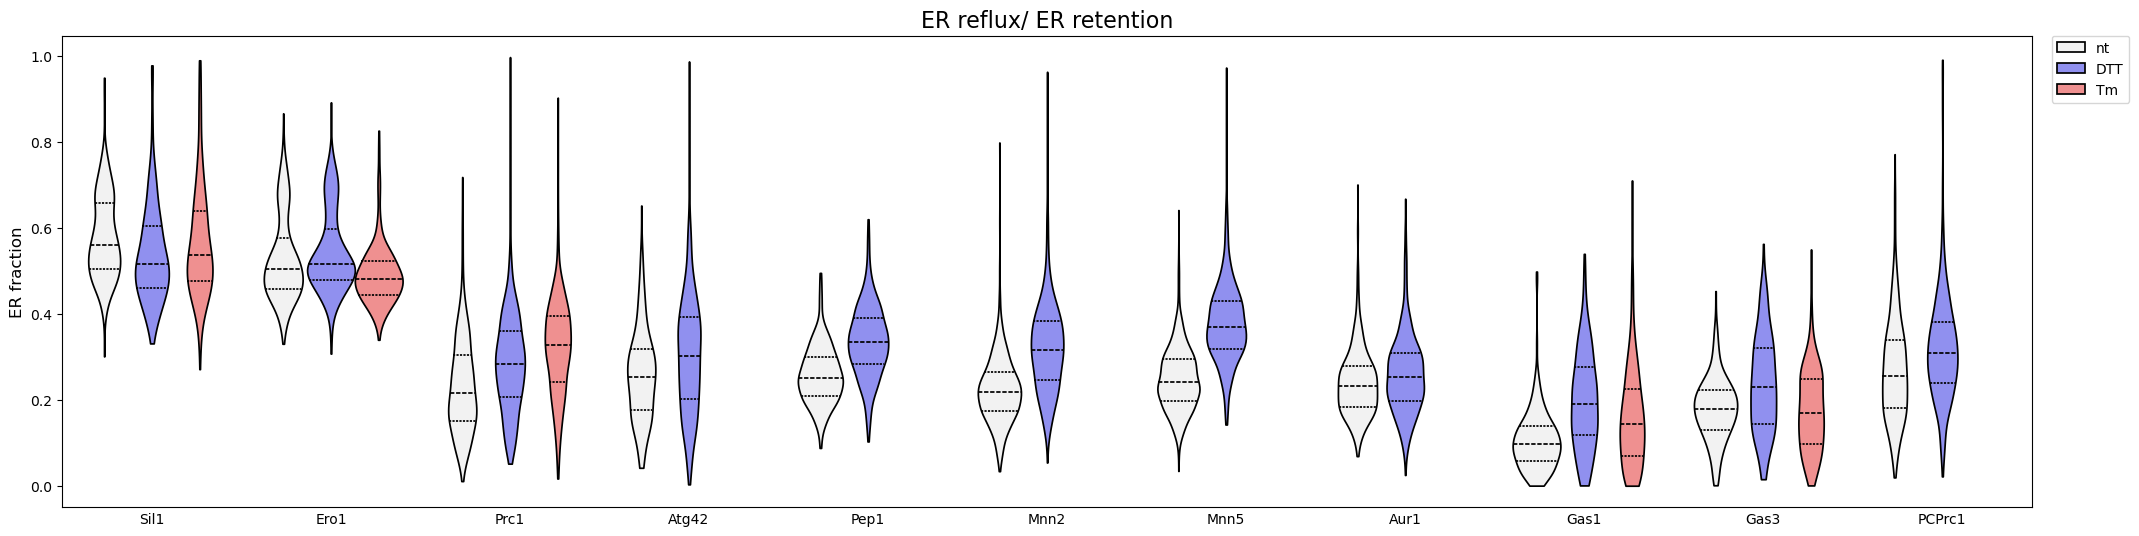

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

"""
Use seaborn library to generate violinplots of all cells per condition and protein
"""

root = tk.Tk()
root.withdraw()

file_dir, df_plot = inrow_plot() #upload excel sheet

# personalize the order
color_map = {
    'nt': '#f2f2f2',
    'DTT': '#8080ff',
    'Tm': '#ff8080'
}
cond_order = {'nt': 0, 'DTT': 1, 'Tm': 2}
chan_order = {
    'Sil1': 1, 'Ero1': 2, 
    'Prc1': 3, 'Atg42':4, 'Pep1': 5, 
    'Mnn2': 6, 'Mnn5':7, 'Aur1':8, 
    'Gas1':9, 'Gas3':10,'PCPrc1':11,
             }

df_plot = (df_plot.stack(["POI", "Condition", "Channel"], future_stack=True).droplevel(0).reset_index().dropna()
           .assign(cond_order=lambda x: x['Condition'].map(cond_order))
           .assign(channel_order=lambda x: x['Channel'].map(chan_order))
           .sort_values(['channel_order', 'cond_order'])
           .drop(columns=['cond_order', 'channel_order'])
          )

fig, axes = plt.subplots(1, 1, figsize=(22, 6))  # n rows, 1 column

#df_plot["POI_Channel"] = df_plot["POI"].astype(str) + "\n" + df_plot["Channel"].astype(str) #combine POI and Channel names in new column
# use the new column for plotting if it's there
if 'POI_Channel' in df_plot.columns:
    x = 'POI_Channel'
    save_path = os.path.join(file_dir, f"Quantification_ALL seperate")
else:
    x = 'Channel'
    #save_path = os.path.join(file_dir, f"Quantification_ALL combined")
    save_path = os.path.join(file_dir, f"Quantification_{", ".join(df_plot['Channel'].unique())} combined")

sns.violinplot(data=df_plot,
               x = x,
               y=plot_col,
               ax=axes,
               hue="Condition", #split=True,
               palette=color_map, dodge=True,
               edgecolor="black",
              inner="quart",
               cut=0 #Seaborn's violinplot uses kernel density estimation (KDE), cut=0 limits KDE to actual data range, no extrapolation
              )

# Customize the first subplot (error bars plot)
axes.set_title(f"ER reflux/ ER retention", fontsize=16)
axes.set_ylabel(f"{plot_col}", fontsize=12)
axes.set_xlabel("")
axes.set_yticks(np.arange(0, 1.05, 0.2)) #ticks from 0.1 to 0.5 with stepsize of 0.1
axes.tick_params(axis='x', length=0)  # "remove" xticks

# Legend outside
axes.legend(
    bbox_to_anchor=(1.01, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(pad=3.0)

# save the plots

saveplots = input("Do you want to save the plots? -yes -no")

if saveplots == "yes":
    plt.savefig(save_path+".svg", 
                format='svg', dpi=300, bbox_inches='tight')  # Save with high resolution, crop whitespace around
    plt.savefig(save_path+".png", 
                dpi=300, bbox_inches='tight')  # Save with high resolution, crop whitespace around

# Show the plot
plt.show()